In [1]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans

covid19-ct-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/covid19-ct-scans.zip

Archive:  /content/covid19-ct-scans.zip
replace ct_scans/coronacases_org_001.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install imgaug

In [3]:
!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [4]:
import glob
import pandas as pd
import numpy as np
import nibabel as nib 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
GPU is available


In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
#import segmentation_models as sm

In [6]:
raw_data = pd.read_csv('/content/metadata.csv')

In [7]:
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
1,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
2,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
4,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [8]:
raw_data.shape

(20, 4)

In [9]:
img_size = 512

In [10]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

In [11]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)
# super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

In [12]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [13]:
all_points1 = []
all_points2 = []

In [14]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 


        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [15]:
cts = []
lungs = []
infections = []

In [16]:
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
1,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
2,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
4,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [17]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [18]:
cts = []
lungs = []
infections = []

for i in range(0,20):
  read_nii(raw_data.loc[i, 'lung_mask'], lungs, 'lungs')
  read_nii(raw_data.loc[i, 'ct_scan'], cts, 'cts')
  read_nii(raw_data.loc[i, 'infection_mask'], infections, 'infections')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


(250, 250) (250, 250)


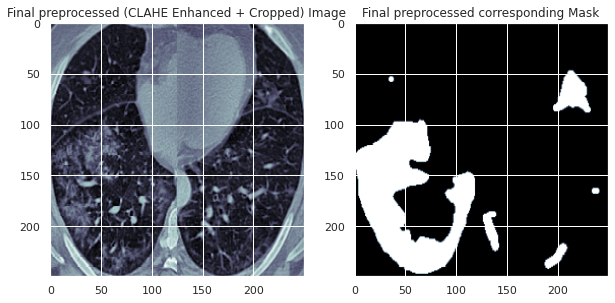

In [19]:
x = 60

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

In [20]:
no_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

for index in sorted(no_masks, reverse = True):  
    del infections[index]  
    del cts[index]
          

Number of complete black masks : 497


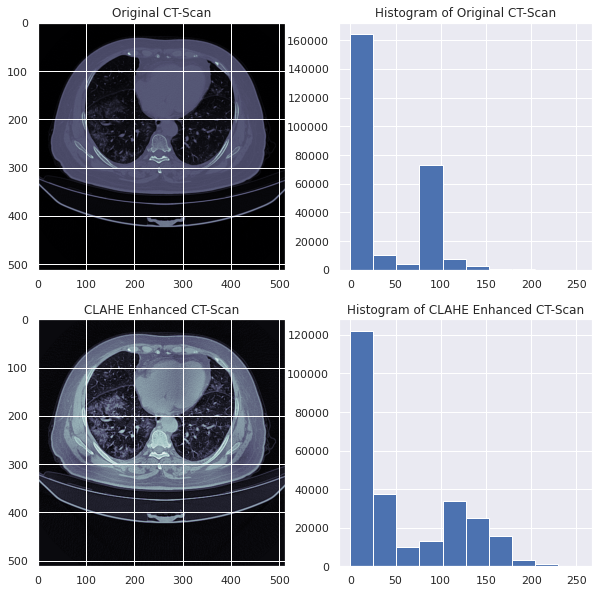

In [21]:
test_file = []
read_nii_demo(raw_data.loc[0, 'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[60], demo = 1)

In [22]:
print(len(cts), len(infections))

1615 1615


In [23]:
dim1 = []
dim2 = []
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)


print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))


An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [24]:
new_dim = 224

In [25]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [26]:
cts = np.array(cts)
infections = np.array(infections)

In [27]:
cts = np.uint8(cts)
infections = np.uint8(infections)

* Data augmentation pipeline

In [28]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [29]:
no_of_aug_imgs = 200
random_indices = np.random.randint(0, cts.shape[0], size = no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [ ]:


cts_aug, infections_aug = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)

In [ ]:
%matplotlib inline
import matplotlib as mpl

In [30]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

NameError: ignored